**Table of contents**<a id='toc0_'></a>    
- [Libraries](#toc1_1_)    
- [Option 1- Search by Ingredients](#toc2_)    
  - [Tokenization](#toc2_1_)    
  - [Modeling](#toc2_2_)    
    - [Word2vec](#toc2_2_1_)    
    - [Hyperparameter Evaluation](#toc2_2_2_)    
    - [Word Embeddings](#toc2_2_3_)    
  - [Vectorisation & Recommendation](#toc2_3_)    
- [Option 2 : Search by Keywords](#toc3_)    
    - [Tokenization](#toc3_1_1_)    
    - [Modeling](#toc3_1_2_)    
      - [Word2Vec](#toc3_1_2_1_)    
      - [Hyperparameter Evaluation](#toc3_1_2_2_)    
    - [Vectorization & Recommendation](#toc3_1_3_)    
- [Option 3 : Search by Ingredients & Keywords both together](#toc4_)    
  - [Tokenization](#toc4_1_)    
  - [Modeling](#toc4_2_)    
  - [Vectorization & Recommendation](#toc4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Importing Dataset & Libraries](#toc0_)


In thi section, I will explore Word2Vec vectorization for modeling and recommendations.

In [4]:
#importing the basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
#importing the word processing libraries


 #importing the regex library
import re

#importing the nltk library
import nltk


#lemmatizer
from nltk.stem import WordNetLemmatizer

#  nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

#defining the stop words
ENGLISH_STOP_WORDS = stopwords.words('english')

#library to handle punctuation
import string

#counter library
from collections import Counter

import spacy

#speech tagging library
from nltk import pos_tag

#library for word embedding
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\e312995\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#loading the cleaned dataset
recipes = pd.read_csv('../Docs/Datasets/recipes_cleaned.csv')

In [7]:
#checking
recipes.shape

(521766, 32)

In [8]:
recipes.columns

Index(['Unnamed: 0', 'RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime',
       'PrepTime', 'TotalTime', 'DatePublished', 'Description', 'Images',
       'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities',
       'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories',
       'FatContent', 'SaturatedFatContent', 'CholesterolContent',
       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
       'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions',
       'length of ingredients', 'length_of_titles', 'Vegan/Not'],
      dtype='object')

# <a id='toc2_'></a>[Option 1- Search by Ingredients](#toc0_)

## <a id='toc2_1_'></a>[Tokenization](#toc0_)

As the next step, I will be refining the ingredients data to avoid biases from different words and to have more consistency for comparsion of the input data vs the recipe data in the database

In Sprint 1, I followed a process where I had multiple lines of codes for each data cleaning step, here I am creating one parser function which can be used to clean both ingredients and title columns. Furthermore in Sprint 1, my ingredients were cleaned in a way that an example of 'red cabbage' would produce 2 tokens red and cabbage seperately, but in the project context, these words should remain in the original form as red cabbage to make sense. So I have changed my cleaning steps to incorporate that.

As the recipes will usually contain alot of measuring terms and this will repeat, I will remove them from the list for the cleaning purpose to remove the biases from them.

Next I will
- break each ingredient list to tokens/words
- lower case
- remove stop words
- remove verbs
- remove measuring word
- remove characters and numbers

All this is done to remove any impact from those words/tokens to the tool as the recommendation engine should only map for the true ingredients.

In [9]:
def parser(input_keys): #function
    
    remove_= { 'oil', 'salt', 'pepper'}

#defining measuring units

    measurment_url= 'https://en.wikibooks.org/wiki/Cookbook:Units_of_measurement' #data source


    measuring_words= ['ml', 'mL', 'milliliter', 'millilitre', 'cc' , 'cubic centimeter', 'l', 'L', 'liter', 'litre', 'dl', 'dL', 'deciliter', 'decilitre', 'teaspoon', 't' , 'tsp.',
'tablespoon' , 'T', 'tbl', 'tbs', 'tbsp', 'fluid ounce', 'fl oz',  'gill', 'cup',  'c', 'pint', 'p', 'pt', 'fl pt',
'quart', 'q', 'qt', 'fl qt', 'gallon' , 'g' , 'gal' , 'g', 'milligram', 'milligramme', 'g' , 'gram' , 'gramme', 'kg',
'kilogram', 'kilogramme', 'pound', 'lb', 'ounce', 'oz', 'mm', 'millimeter', 'millimetre', 'cm' , 'centimeter', 'centimetre', 'm' , 'meter',
'metre', 'inch', 'in', 'yard', '°C' , 'degree celsius','°F' ,'Farenheit', 'tsp']



    ingredients_list = re.split(',', input_keys) #splitting the ingredients by commas

    cleaned_ingredients = [] #new list to store cleaned ingredients

    lemmatizer = WordNetLemmatizer() #lemmatizer

    for ingredient in ingredients_list:
        items = re.split(' ', ingredient)  #splitting each ingredient by space to process and clean each individual word

        items = [word for word in items if word.isalpha()] #filtering only letters

        items = [word.lower() for word in items] #lowercasing

        items = [lemmatizer.lemmatize(word) for word in items] #lemmatizing

        items = [word for word in items if word not in ENGLISH_STOP_WORDS] #removing stop words

        items = [word for word in items if word not in measuring_words] #removing measuring words

        items = [word for word in items if word not in remove_]

        if items:
            cleaned_ingredients.append(' '.join(items) ) #joining the individual words of the ingredient seperated by space
    

    return cleaned_ingredients #return the list


Perfect, I have my ingredients seperated by a comma in original form.

## <a id='toc2_2_'></a>[Modeling](#toc0_)

### <a id='toc2_2_1_'></a>[Word2vec](#toc0_)

Since this is a text analysis, I will use Word2vec which will enable creating embeddings for each word which then can be  converted to a vector for further analysis.

In [10]:
ingredients= recipes['RecipeIngredientParts']
ingredients

0         blueberries, granulated sugar, vanilla yogurt,...
1         saffron, milk, hot green chili peppers, onions...
2         sugar, lemons, rind of, lemon, zest of, fresh ...
3         extra firm tofu, eggplant, zucchini, mushrooms...
4         plain tomato juice, cabbage, onion, carrots, c...
                                ...                        
521761    fresh ginger, unsalted butter, dark brown suga...
521762    Dijon mustard, garlic, peppercorns, shallot, c...
521763            half-and-half, heavy cream, brandy, sugar
521764    wasabi paste, dill, English cucumber, smoked s...
521765    hard-boiled eggs, breakfast sausage, panko bre...
Name: RecipeIngredientParts, Length: 521766, dtype: object

In [11]:
#getting the parsed ingredients for the model
ingredients= recipes['RecipeIngredientParts']
ingredients_cleaned = ingredients.apply(parser)

#word2vec model with starting parameters
phrases_model=Word2Vec(sentences=ingredients_cleaned,min_count=1, sg=0, window=15, workers=8, vector_size=300, compute_loss=True)  #used min_count=1 to avoid any ingredient being missed out

### <a id='toc2_2_2_'></a>[Hyperparameter Evaluation](#toc0_)

Now I will check different options with the model to check which gives the lowest compute loss

In [12]:
#loss with vector size 300
phrases_model.get_latest_training_loss()

3262806.25

In [13]:
#vector size 200
phrases_model=Word2Vec(sentences=ingredients_cleaned,min_count=1, sg=0, window=15, workers=8, vector_size=200, compute_loss=True)
phrases_model.get_latest_training_loss()

3279630.5

In [14]:
#vector size 100
phrases_model=Word2Vec(sentences=ingredients_cleaned,min_count=1, sg=0, window=15, workers=8, vector_size=100, compute_loss=True)
phrases_model.get_latest_training_loss()

3348118.75

I am also going to iterate through hs, window, vector sizes to see if I can pick the best hyperparamters

import time

train_time_values = []
seed_val = 42

hs_values = [0, 1]
vector_values= [100,200,300]
window_values= [10,13,15,18]



for data in ingredients_cleaned:
    for vector in vector_values:
        for hs_val in hs_values:
            for window in window_values:
                time_taken_list = []
                for i in range(3):
                    start_time = time.time()
                    w2v_model = Word2Vec(
                        data,
                        compute_loss=True,
                        window= window,
                        vector_size=vector,
                        hs=hs_val,
                        seed=seed_val,
                    )
                    time_taken_list.append(time.time() - start_time)

                time_taken_list = np.array(time_taken_list)
                time_mean = np.mean(time_taken_list)
                time_std = np.std(time_taken_list)

                model_result = {
                
                    'compute_loss': w2v_model.get_latest_training_loss(),
                    'vector': vector,
                    'window': window,
                    'hs_val': hs_val,
                    'train_time_mean': time_mean,
                    'train_time_std': time_std,
                }
                print("Word2vec model #%i: %s" % (len(train_time_values), model_result))
                train_time_values.append(model_result)

train_times_table = pd.DataFrame(train_time_values)
train_times_table = train_times_table.sort_values(
    by=['train_data',  'hs', 'compute_loss'],
    ascending=[False, False, False],
)
print(train_times_table)

As per above, vector size 100, window size=15 and hs_val=0 gives the lowest loss factor, Combining with the earlier training losses, I will proceed with below. 

Final model selection:
 - vector size= 200
 - hs= 0
 - window= 15

In [15]:
#final model
phrases_model=Word2Vec(sentences=ingredients_cleaned,min_count=1, sg=0, window=15, workers=8, vector_size=100, compute_loss=True, hs=0)

In [16]:
#saving the model
phrases_model.save('../Models/Word2Vec/phrases_model_new(op1).bin')


### <a id='toc2_2_3_'></a>[Word Embeddings](#toc0_)

Checking similar words to different ingredients if the model has been trained well.  

In [17]:
#getting the word embeddings to compare different ingredients
embeddings= {word: phrases_model.wv[word] for word in phrases_model.wv.index_to_key} 

In [18]:
print(phrases_model.wv.most_similar(u'onion', topn=5)) #checking the most similar results for onion

[('yellow onion', 0.8028221130371094), ('sweet onion', 0.7337679266929626), ('spanish onion', 0.7247664928436279), ('cooking onion', 0.6490809321403503), ('red onion', 0.5940496921539307)]


In [19]:
print(phrases_model.wv.most_similar(u'garlic', topn=5)) #again checkin the most similar words to garlic

[('garlic clove', 0.9546293020248413), ('minced garlic clove', 0.9053474068641663), ('fresh garlic', 0.8443818688392639), ('fresh garlic clove', 0.7994007468223572), ('bulb garlic', 0.672409176826477)]


In [20]:
phrases_model.wv.most_similar(['cheese', 'pasta'], topn=10) #checking for cheese pasta

[('penne', 0.7372098565101624),
 ('dry pasta', 0.7251143455505371),
 ('penne pasta', 0.7169134020805359),
 ('rigatoni pasta', 0.7127609848976135),
 ('pasta shell', 0.7002800703048706),
 ('shell pasta', 0.6783171892166138),
 ('farfalle pasta', 0.677629828453064),
 ('parmigiano', 0.6657990217208862),
 ('parmesan cheese', 0.6590689420700073),
 ('pecorino romano cheese', 0.651828944683075)]

I will try to use a tile map to show the similarity of a few ingredients

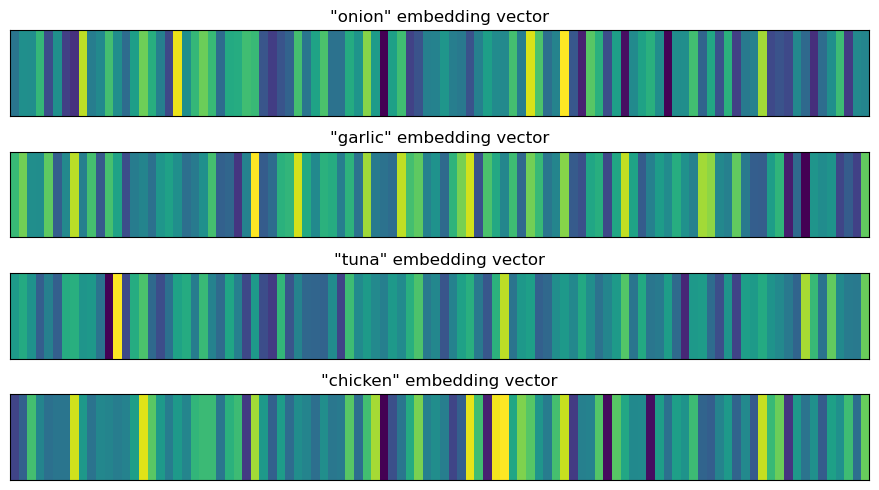

In [21]:
word_list = ['onion', 'garlic', 'tuna', 'chicken'] #example

plt.subplots(len(word_list), 1, figsize=(20, 5)) #plot

for i, word in enumerate(word_list): #for loop to get each word in the list
    plt.subplot(len(word_list), 1, i + 1) #subplot
    plt.imshow(np.tile(embeddings[word], (10, 1))) #data
    plt.xticks([]) #no xticks
    plt.yticks([]) #no yticks
    plt.title(f"\"{word}\" embedding vector") #title

plt.tight_layout()
plt.show()

It is visible that words represent different distributions. Looks good. 

## <a id='toc2_3_'></a>[Vectorisation & Recommendation](#toc0_)

In [62]:
# user Input Processing
user_input = 'egg', 'rice'  # User's input

def recommender(user_input):

    #parsing the user input
    user_input = ','.join(map(str, user_input)) #converting to str, mapping and joining by the ','
    
    user_input.split(',')

    user_input=parser(user_input)
    


# mean Embeddings for User Input
    user_mean_vector =np.mean([phrases_model.wv[ingredient] for ingredient in user_input if ingredient in phrases_model.wv] or [np.zeros(100)], axis=0)



# check if user_mean_vector contains NaN values
    if np.isnan(user_mean_vector).any():
        print("User input vectors contain NaN values.")


    else:

    # mean ingredient vectors for each recipe
        recipe_vectors = [np.mean([phrases_model.wv[sub_ingredient] for sub_ingredient in ingredient if sub_ingredient in phrases_model.wv] or [np.zeros(100)], axis=0) for ingredient in ingredients_cleaned]





    # Check if any recipe vector contains NaN values
        if not recipe_vectors:
            print('nothing obtained for recipe vectors')

        else:
        
        # cosine similarity between user mean vector and recipe mean vectors
            cosine_similarities = cosine_similarity([user_mean_vector], recipe_vectors)


        # indices of top N most similar recipes
            top_recipes = np.argsort(cosine_similarities[0])[::-1][:5]



            recommendation= pd.DataFrame( columns=['Title','Ingredients', 'Category', 'Calories', 'Time', 'Score'] ) #dataframe with columns

    
            for i in top_recipes: #defining the data for each recommendation

            
                title = recipes['Name'].iloc[i]
                calories = recipes['Calories'].iloc[i]
                time= recipes['TotalTime'].iloc[i]
                ingredients = recipes['RecipeIngredientParts'].iloc[i]
                category= recipes['RecipeCategory'].iloc[i]
                score= cosine_similarities[0][i]
                
                recommendation = pd.concat([recommendation,pd.DataFrame(
                                    {'Title': [title], 
                                    'Ingredients': [ingredients], 
                                    'Category' : [category],
                                    'Calories': [calories], 
                                     'Time': [time],
                                     'Score': [score]})], 
                                        ignore_index=True)




    return recommendation  


In [63]:
user_input = 'cabbage', 'carrot'


recommender(user_input)



C:\Users\e312995\AppData\Local\Temp\ipykernel_9604\916188151.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recommendation = pd.concat([recommendation,pd.DataFrame(


,Title,Ingredients,Category,Calories,Time,Score
0,Tibetan Cabbage Salad (Tangtse),"white cabbage, daikon radish, carrot, salt",Vegetable,52.5,PT10M,0.878855
1,Et-Su-Put (Boiled Pork With Vegetables),"water, potatoes, carrot, cabbage",Pork,548.9,PT3H10M,0.877806
2,Vinegret. Russian Vegetarian Salad,"carrot, beet, pickled cucumbers, cabbage, kidn...",Potato,65.8,PT50M,0.874926
3,Coleslaw With Herbed Vinaigrette,"cabbage, carrot, onion, Herbed Vinaigrette",< 60 Mins,44.9,PT35M,0.870475
4,Easy Ramen Stir-Fry,"onion, cabbage, carrot",Lunch/Snacks,34.0,PT20M,0.869278


# <a id='toc3_'></a>[Option 2 : Search by Keywords](#toc0_)

I now will give the option to the user to search recipes using keywords present in the recipe database. For that I wil use the columns containing key attributes, 'Title', 'RecipeCategory', 'Keywords' and follow the same process as earlier.

### <a id='toc3_1_1_'></a>[Tokenization](#toc0_)

In [29]:
#combining the 3 columns data to one
recipes['text_data']= recipes[['Name', 'RecipeCategory', 'Keywords']].astype(str).agg(','.join, axis=1) 

In [30]:
#sanity check
recipes['text_data']

0         Low-Fat Berry Blue Frozen Dessert,Frozen Desse...
1         Biryani,Chicken Breast,c("Chicken Thigh & Leg"...
2         Best Lemonade,Beverages,c("Low Protein", "Low ...
3         Carina's Tofu-Vegetable Kebabs,Soy/Tofu,c("Bea...
4         Cabbage Soup,Vegetable,c("Low Protein", "Vegan...
                                ...                        
521761    Meg's Fresh Ginger Gingerbread,Dessert,"< 4 Ho...
521762    Roast Prime Rib au Poivre with Mixed Peppercor...
521763    Kirshwasser Ice Cream,Ice Cream,c("Dessert", "...
521764    Quick & Easy Asian Cucumber Salmon Rolls,Canad...
521765        Spicy Baked Scotch Eggs,Breakfast,"< 60 Mins"
Name: text_data, Length: 521766, dtype: object

In [53]:
#parser

text_data= recipes['text_data']

def parser_text(input_keys): #function


#defining measuring units

    measurment_url= 'https://en.wikibooks.org/wiki/Cookbook:Units_of_measurement' #data source

    remove_= ['mins']#removing the word mins to avoid biases and give results based on true mins in digit format


    measuring_words= ['ml', 'mL', 'milliliter', 'millilitre', 'cc' , 'cubic centimeter', 'l', 'L', 'liter', 'litre', 'dl', 'dL', 'deciliter', 'decilitre', 'teaspoon', 't' , 'tsp.',
'tablespoon' , 'T', 'tbl', 'tbs', 'tbsp', 'fluid ounce', 'fl oz',  'gill', 'cup',  'c', 'pint', 'p', 'pt', 'fl pt',
'quart', 'q', 'qt', 'fl qt', 'gallon' , 'g' , 'gal' , 'g', 'milligram', 'milligramme', 'g' , 'gram' , 'gramme', 'kg',
'kilogram', 'kilogramme', 'pound', 'lb', 'ounce', 'oz', 'mm', 'millimeter', 'millimetre', 'cm' , 'centimeter', 'centimetre', 'm' , 'meter',
'metre', 'inch', 'in', 'yard', '°C' , 'degree celsius','°F' ,'Farenheit', 'tsp']



    ingredients_list = re.split(',', input_keys) #splitting the ingredients by commas
    ingredients_list = re.split(' ', input_keys) #splitting the ingredients by commas

    cleaned_ingredients = [] #new list to store cleaned ingredients

    lemmatizer = WordNetLemmatizer() #lemmatizer

    for ingredient in ingredients_list:
        items = re.split(',', ingredient)  #splitting each ingredient by space to process and clean each individual word

        items = [word for word in items if word.isalpha()] #filtering only letters


        items = [word.lower() for word in items] #lowercasing

        items = [lemmatizer.lemmatize(word) for word in items] #lemmatizing

        items = [word for word in items if word not in ENGLISH_STOP_WORDS] #removing stop words

        items = [word for word in items if word not in measuring_words] #removing measuring words

        if items:
            cleaned_ingredients.append(','.join(items) ) #joining the individual words of the ingredient seperated by space
        #cleaned_ingredients= ' '.join(cleaned_ingredients) #joining the ingreidents back seprated by commas


    return cleaned_ingredients #return the list


### <a id='toc3_1_2_'></a>[Modeling](#toc0_)

#### <a id='toc3_1_2_1_'></a>[Word2Vec](#toc0_)

In [54]:
#applying the parser to the text data to be used in model training
text_data_cleaned = text_data.apply(parser_text)
recipes['TextDataCleaned']= text_data_cleaned

In [55]:
#vector size 100
phrases_model_2=Word2Vec(sentences=text_data_cleaned,min_count=1, sg=0, window=20, workers=8, vector_size=100, compute_loss=True) #word2vec model, used min_count=1 to avoid any ingredient being missed out
phrases_model_2.get_latest_training_loss()

2153388.25

#### <a id='toc3_1_2_2_'></a>[Hyperparameter Evaluation](#toc0_)

In [56]:
#vector size 200
phrases_model_2=Word2Vec(sentences=text_data_cleaned,min_count=1, sg=0, window=20, workers=8, vector_size=200, compute_loss=True)
phrases_model_2.get_latest_training_loss()

2062263.125

In [57]:
#vector size 300
phrases_model_2=Word2Vec(sentences=text_data_cleaned,min_count=1, sg=0, window=20, workers=8, vector_size=300, compute_loss=True)
phrases_model_2.get_latest_training_loss()

2101812.75

import time

train_time_values = []
seed_val = 42

hs_values = [0, 1]
vector_values= [100,200,300]
window_values= [10,15, 20, 25, 30]

for data in text_data_cleaned:
    for vector in vector_values:
        for hs_val in hs_values:
            for window in window_values:
                time_taken_list = []
                for i in range(3):
                    start_time = time.time()
                    w2v_model = Word2Vec(
                        data,
                        compute_loss=True,
                        window= window,
                        vector_size=vector,
                        hs=hs_val,
                        seed=seed_val,
                    )
                    time_taken_list.append(time.time() - start_time)

                time_taken_list = np.array(time_taken_list)
                time_mean = np.mean(time_taken_list)
                time_std = np.std(time_taken_list)

                model_result = {
                    
                    'compute_loss': w2v_model.get_latest_training_loss(),
                    'vector': vector,
                    'window': window,
                    'hs_val': hs_val,
                    'train_time_mean': time_mean,
                    'train_time_std': time_std,
                }
                print("Word2vec model #%i: %s" % (len(train_time_values), model_result))
                train_time_values.append(model_result)

train_times_table = pd.DataFrame(train_time_values)
train_times_table = train_times_table.sort_values(
    by=['train_data',  'hs', 'compute_loss'],
    ascending=[False, False, False],
)
print(train_times_table)

In [58]:
#final model
phrases_model_2=Word2Vec(sentences=text_data_cleaned,min_count=1, sg=0, window=25, workers=8, vector_size=300, compute_loss=True)

#saving the model
phrases_model_2.save('../Models/Word2Vec/phrases_model_new(op2).bin')


### <a id='toc3_1_3_'></a>[Vectorization & Recommendation](#toc0_)

In [59]:
def recommender_text(text_input):

    user_input= parser_text(text_input)

    # Mean Embeddings for User Input
    user_mean_vector =np.mean([phrases_model_2.wv[user_text] for user_text in user_input if user_text in phrases_model_2.wv] or [np.zeros(300)], axis=0)



    # check if user_mean_vector contains NaN values
    if np.isnan(user_mean_vector).any():
        print("User input vectors contain NaN values.")


    else:

        # mean ingredient vectors for each recipe
        text_vectors = [np.mean([phrases_model_2.wv[sub_text] for sub_text in text if sub_text in phrases_model_2.wv] or [np.zeros(300)], axis=0) for text in text_data_cleaned]





        # Check if any recipe vector contains NaN values
        if not text_vectors:
            print('nothing obtained for recipe vectors')

        else:
            
            # cosine similarity between user mean vector and recipe mean vectors
            cosine_similarities_text= cosine_similarity([user_mean_vector], text_vectors)


            # indices of top N most similar recipes
            top_recipes = np.argsort(cosine_similarities_text[0])[::-1][:5]



            recommendation= pd.DataFrame( columns=['title','ingredients', 'description', 'keywords', 'category', 'score'] ) #dataframe with columns

    
            for i in top_recipes: #defining the data for each recommendation

                
                title = recipes['Name'].iloc[i],
                description= recipes['Description'].iloc[i,]
                keywords = recipes['Keywords'].iloc[i]
                category= recipes['RecipeCategory'].iloc[i]
                ingredients = recipes['RecipeIngredientParts'].iloc[i]
                score= cosine_similarities_text[0][i]
                # recommendation = recommendation.concat([
                #                     {'title': title, 
                #                     'description': description,
                #                     'ingredients': ingredients, 
                #                     'keywords' : keywords, 
                #                     'category' : category, 
                #                     'score': score}], 
                #                         ignore_index=True)
                recommendation = pd.concat([recommendation,pd.DataFrame(
                                    {'title': [title], 
                                    'description': [description],
                                    'ingredients': [ingredients], 
                                    'keywords' : [keywords], 
                                    'category' : [category], 
                                    'score': [score]})], 
                                        ignore_index=True)




    return recommendation

       





In [60]:
# user Input Processing
text_input = 'cabbage soup'  # user's input

recommender_text(text_input)

C:\Users\e312995\AppData\Local\Temp\ipykernel_9604\2993598005.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recommendation = pd.concat([recommendation,pd.DataFrame(


,title,ingredients,description,keywords,category,score
0,"(Cabbage Soup Spicy,)","cabbage, onion, celery, mushroom, stewed tomat...",This is a take on the cabbage soup diet for th...,"c(""Vegetable"", ""Low Protein"", ""Low Cholesterol...",Onions,0.999991
1,"(Cabbage Soup With Flair,)","garlic cloves, celery, carrots, cabbage, onion...",I have read many recipies for cabbage soup and...,"c(""< 60 Mins"", ""Inexpensive"")",Vegetable,0.999940
2,"(Cabbage Soup for the Financially Impaired,)","onion, head of cabbage, barley, beef bouillon ...",An easy and CHEAP meal... Great for those tim...,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...",Vegetable,0.999934
3,"(Cabbage Soup, Valtellina Style,)","savoy cabbage, salt, pepper, Fontina cheese, b...","Make and share this Cabbage Soup, Valtellina S...","c(""Cheese"", ""Winter"", ""< 30 Mins"", ""Easy"", ""In...",Stocks,0.999907
4,"(Cabbage Soup With Sausage,)","sausages, olive oil, onion, leek, carrots, cho...",A lovely little recipe from the '365 a day' co...,"c(""Pork"", ""Meat"", ""Savory"", ""Stove Top"", ""< 4 ...",Stocks,0.999899


# <a id='toc4_'></a>[Option 3 : Search by Ingredients & Keywords both together](#toc0_)

## <a id='toc4_1_'></a>[Tokenization](#toc0_)

In [64]:
#combining the 4 columns data to one
recipes['text_data_all']= recipes[['Name', 'RecipeCategory', 'Keywords', 'RecipeIngredientParts']].astype(str).agg(','.join, axis=1) 
#sanity check
recipes['text_data_all'][0]

'Low-Fat Berry Blue Frozen Dessert,Frozen Desserts,c("Dessert", "Low Protein", "Low Cholesterol", "Healthy", "Free Of...", "Summer", "Weeknight", "Freezer", "Easy"),blueberries, granulated sugar, vanilla yogurt, lemon juice'

In [65]:
#parser
def parser_text(input_keys): #function


    # Defining measuring units
    remove_ = {'oil', 'salt', 'pepper' , 'mins'}


    # Defining measuring units
    measuring_words = ['ml', 'mL', 'milliliter', 'millilitre', 'cc', 'cubic centimeter', 'l', 'L', 'liter', 'litre', 'dl',
                   'dL', 'deciliter', 'decilitre', 'teaspoon', 't', 'tsp.', 'tablespoon', 'T', 'tbl', 'tbs', 'tbsp',
                   'fluid ounce', 'fl oz', 'gill', 'cup', 'c', 'pint', 'p', 'pt', 'fl pt', 'quart', 'q', 'qt', 'fl qt',
                   'gallon', 'g', 'gal', 'g', 'milligram', 'milligramme', 'g', 'gram', 'gramme', 'kg', 'kilogram',
                   'kilogramme', 'pound', 'lb', 'ounce', 'oz', 'mm', 'milimeter', 'millimetre', 'cm', 'centimeter',
                   'centimetre', 'm', 'meter', 'metre', 'inch', 'in', 'yard', '°C', 'degree celsius', '°F', 'Farenheit', 'tsp']

    cleaned_ingredients_all_recipes = []
    
    for each_ingredient_list in input_keys:
            comma_list = re.split(',', each_ingredient_list)  # splitting the ingredients by commas


            cleaned_ingredients = []  # new list to store cleaned ingredients for a single recipe


            lemmatizer = WordNetLemmatizer()  # lemmatize


            for each_word_set in comma_list:
                items = [word.lower() for word in re.findall(r'\b\w+\b', each_word_set)]  # Extract individual words and convert to lowercase


                items = [word for word in items if word.isalpha()]  # filtering only letters

                items = [lemmatizer.lemmatize(word) for word in items]  # lemmatizing


                items = [word for word in items if word not in ENGLISH_STOP_WORDS]  # removing stop words


                items = [word for word in items if word not in measuring_words]  # removing measuring words


                items = [word for word in items if word not in remove_]


                if items:
                    cleaned_ingredients.extend(items)


            cleaned_ingredients_all_recipes.append(cleaned_ingredients)

    return(cleaned_ingredients_all_recipes)


## <a id='toc4_2_'></a>[Modeling](#toc0_)

In [66]:
text_data_all= recipes['text_data_all']
text_data_all_cleaned=parser_text(text_data_all)

In [67]:
#vector size 100
phrases_model_3=Word2Vec(sentences=text_data_all_cleaned,min_count=1, sg=0, window=35, workers=8, vector_size=200, compute_loss=True) #word2vec model, used min_count=1 to avoid any ingredient being missed out
phrases_model_3.get_latest_training_loss()

7796189.5

In [68]:
phrases_model_3=Word2Vec(sentences=text_data_all_cleaned,min_count=1, sg=0, window=35, workers=8, vector_size=100, compute_loss=True) #word2vec model, used min_count=1 to avoid any ingredient being missed out
phrases_model_3.get_latest_training_loss()

8301390.5

In [69]:
phrases_model_3=Word2Vec(sentences=text_data_all_cleaned,min_count=1, sg=0, window=35, workers=8, vector_size=300, compute_loss=True) #word2vec model, used min_count=1 to avoid any ingredient being missed out
phrases_model_3.get_latest_training_loss()

8018258.5

import time   
train_time_values = []
seed_val = 42

hs_values = [0, 1]
vector_values= [100,200,300]
window_values= [10, 20, 25, 30]


for data in text_data_all_cleaned:
    for vector in vector_values:
        for hs_val in hs_values:
            for window in window_values:
                time_taken_list = []
                for i in range(3):
                    start_time = time.time()
                    w2v_model = Word2Vec(
                        data,
                        compute_loss=True,
                        window= window,
                        vector_size=vector,
                        hs=hs_val,
                        seed=seed_val,
                    )
                    time_taken_list.append(time.time() - start_time)

                time_taken_list = np.array(time_taken_list)
                time_mean = np.mean(time_taken_list)
                time_std = np.std(time_taken_list)

                model_result = {
                    
                    'compute_loss': w2v_model.get_latest_training_loss(),
                    'vector': vector,
                    'window': window,
                    'hs_val': hs_val,
                    'train_time_mean': time_mean,
                    'train_time_std': time_std,
                }
                print("Word2vec model #%i: %s" % (len(train_time_values), model_result))
                train_time_values.append(model_result)

train_times_table = pd.DataFrame(train_time_values)
train_times_table = train_times_table.sort_values(
    by=['train_data',  'hs', 'compute_loss'],
    ascending=[False, False, False],
)
print(train_times_table)

In [70]:
phrases_model_3=Word2Vec(sentences=text_data_all_cleaned,min_count=1, sg=0, window=30, workers=8, vector_size=100, compute_loss=True) #word2vec model, used min_count=1 to avoid any ingredient being missed out


## <a id='toc4_3_'></a>[Vectorization & Recommendation](#toc0_)

In [71]:
def recommender_text_all(text_input):

    user_input= parser(text_input)

    # Mean Embeddings for User Input
    user_mean_vector =np.mean([phrases_model_3.wv[user_text] for user_text in user_input if user_text in phrases_model_3.wv] or [np.zeros(100)], axis=0)



    # check if user_mean_vector contains NaN values
    if np.isnan(user_mean_vector).any():
        print("User input vectors contain NaN values.")


    else:

        # mean ingredient vectors for each recipe
        text_vectors = [np.mean([phrases_model_3.wv[sub_text] for sub_text in text if sub_text in phrases_model_3.wv] or [np.zeros(100)], axis=0) for text in text_data_all_cleaned]





        # Check if any recipe vector contains NaN values
        if not text_vectors:
            print('nothing obtained for recipe vectors')

        else:
            
            # cosine similarity between user mean vector and recipe mean vectors
            cosine_similarities_text= cosine_similarity([user_mean_vector], text_vectors)


            # indices of top N most similar recipes
            top_recipes = np.argsort(cosine_similarities_text[0])[::-1][:5]



            recommendation= pd.DataFrame( columns=['title','ingredients', 'description', 'keywords', 'category', 'score'] ) #dataframe with columns

    
            for i in top_recipes: #defining the data for each recommendation

                
                title = recipes['Name'].iloc[i],
                description= recipes['Description'].iloc[i,]
                keywords = recipes['Keywords'].iloc[i]
                category= recipes['RecipeCategory'].iloc[i]
                ingredients = recipes['RecipeIngredientParts'].iloc[i]
                score= cosine_similarities_text[0][i]
                recommendation = pd.concat([recommendation,pd.DataFrame(
                                    {'title': [title], 
                                    'description': [description],
                                    'ingredients': [ingredients], 
                                    'keywords' : [keywords], 
                                    'category' : [category], 
                                    'score': [score]})], 
                                        ignore_index=True)




    return recommendation

       





In [72]:
user_input= 'soup, cabbage, carrot, onion'
recommender_text_all(user_input)

C:\Users\e312995\AppData\Local\Temp\ipykernel_9604\1809556674.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recommendation = pd.concat([recommendation,pd.DataFrame(


,title,ingredients,description,keywords,category,score
0,"(Maghero's Soup,)","cabbage, cabbage, carrots, celery ribs, onion,...",Make and share this Maghero's Soup recipe from...,"c(""Beans"", ""European"", ""< 4 Hours"")",Clear Soup,0.805033
1,"(Sausage Cabbage Soup,)","cabbage, chicken broth, pepper, salt, flour, m...",Make and share this Sausage Cabbage Soup recip...,"c(""< 4 Hours"", ""Easy"")",Clear Soup,0.798831
2,"(Diet Cabbage Soup,)","carrots, zucchini, bell peppers, celery ribs, ...","My mom wanted to try this diet, and made a hug...","c(""Weeknight"", ""Stove Top"", ""< 4 Hours"")",Vegetable,0.795229
3,"(Autumn Harvest Root Vegetable Soup,)","carrots, parsnips, cabbage, onion, celery ribs...",Make and share this Autumn Harvest Root Vegeta...,"c(""Vegetable"", ""< 60 Mins"")",Clear Soup,0.789172
4,"(Cabbage Soup,)","butter, onion, turnip, cabbage, salt, pepper, ...",Make and share this Cabbage Soup recipe from F...,"""Inexpensive""",< 30 Mins,0.789108


In [73]:
recipes.to_csv('../Docs/Datasets/recipes_streamlit.csv')